In [1]:
!pip install --upgrade --no-cache-dir gdown

# !gdown 1Foy57BMvQe4GOcZr1g0lmdFXvmQ1lEVy
# !unzip /content/file.zip

!gdown 1ZJ63jCjYwyppH7gvQ7mI9JGJ4ctuvWHf
!gdown 1hvJWoeP55YDLZMVgBLL1GDQvOft7-0GM
!gdown 1yEx6oREp6eHj1ASg4nTf1ynvEG7RUymf

!gdown 1WA5WUH9ueU1stupYueiju2ghquW2lpyW
!gdown 12QyksJjmwP5oHXh-4D-XZQjiQ6FLCDN4

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From (uriginal): https://drive.google.com/uc?id=1ZJ63jCjYwyppH7gvQ7mI9JGJ4ctuvWHf
From (redirected): https://drive.google.com/uc?id=1ZJ63jCjYwyppH7gvQ7mI9JGJ4ctuvWHf&confirm=t&uuid=1c96e669-531a-40a3-8145-963d5c57f5f0
To: /content/Normal_VGG.pth
100% 59.0M/59.0M [00:00<00:00, 177MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1hvJWoeP55YDLZMVgBLL1GDQvOft7-0GM
From (redirected): https://drive.google.com/uc?id=1hvJWoeP55YDLZMVgBLL1GDQvOft7-0GM&confirm=t&uuid=d95bb1a1-9eca-4bba-a389-93cef7effc29
To: /content/VGG_Without_MP.pth
100% 49.5M/49.5M [00:00<00:00, 102MB/s] 
Downloading...
From (uriginal): https://drive.google.com/uc?id=1yEx6oREp6eHj1ASg4nTf1ynvEG7RUymf
From (redirected): https://drive.google.com/uc?id=1yEx6oREp6eHj1ASg4nTf1ynvEG7RUymf&confirm=t&uuid=15d47511-fb8a-4b42-8006-22bc9eb6fa7b
To: /content

In [2]:
pip install git+https://github.com/jeromerony/fast_adversarial

  Cloning https://github.com/jeromerony/fast_adversarial to /tmp/pip-req-build-mw6xndqe
  Running command git clone --filter=blob:none --quiet https://github.com/jeromerony/fast_adversarial /tmp/pip-req-build-mw6xndqe
  Resolved https://github.com/jeromerony/fast_adversarial to commit 45210b7c79e2deaeac9845d6c901dc2580d6e316
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for fast-adversarial: filename=fast_adversarial-0.1-py3-none-any.whl size=29326 sha256=86c473ec80c3a037905858934f823e478d6f66fde502c0eabde1d1dfdb98fc26
  Stored in directory: /tmp/pip-ephem-wheel-cache-bv3sta8j/wheels/d6/68/b8/b4ae3dd5ec7d260836ef6dbd54028

In [3]:
import argparse
import torch
import time
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import warnings
warnings.filterwarnings('ignore')
from vgg import VGG
from fast_adv.attacks import DDN, CarliniWagnerL2
from fast_adv.utils import requires_grad_, l2_norm
import matplotlib.pyplot as plt
import os
%matplotlib inline

torch.manual_seed(42)
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = 'data/cifar10'  # Change this if you already downloaded CIFAR-10 elsewhere
model_path = '/content/VGG_Without_MP.pth'  # Specify the path to your model file

100%|██████████| 170498071/170498071 [00:05<00:00, 29233104.01it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10


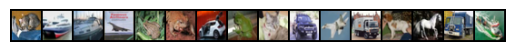

In [4]:
# Loading the data
dataset = datasets.CIFAR10(data_path, train=False,
                         transform=transforms.ToTensor(),
                         download=True)
loader = data.DataLoader(dataset, shuffle=False, batch_size=16)

x, y = next(iter(loader))
x = x.to(device)
y = y.to(device)

x_cpu = x.cpu()
grid_image = make_grid(x_cpu, nrow=16).permute(1, 2, 0)
plt.imshow(grid_image)
plt.axis('off')
plt.show()


In [5]:
import torch
import torch.nn as nn

print('Loading model')

if not os.path.exists(model_path):
    import urllib
    print('Downloading model')
    urllib.request.urlretrieve(model_url, model_path)


model = VGG(vgg_name='VGG16', pretrained=True)
model = nn.DataParallel(model)
checkpoint = torch.load(r"/content/VGG_Without_MP.pth")
# model.load_state_dict(torch.load(model_path))
model.load_state_dict(checkpoint['net'])
model.eval().to(device)
requires_grad_(model, False)

Loading model


Running DDN 100 attack
Completed in 14.15s


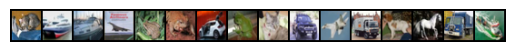

In [6]:
print('Running DDN 100 attack')
attacker = DDN(steps=100, device=device)
start = time.time()
ddn_atk = attacker.attack(model, x, labels=y, targeted=False)
ddn_time = time.time() - start
print('Completed in {:.2f}s'.format(ddn_time))

plt.imshow(make_grid(ddn_atk.cpu(), nrow=16).permute(1, 2, 0))
plt.axis('off');

Running C&W 4 x 25 attack (limited to 100 iterations)
Completed in 0.90s


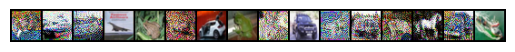

In [8]:
print('Running C&W 4 x 25 attack (limited to 100 iterations)')
cwattacker100 = CarliniWagnerL2(device=device,
                             image_constraints=(0, 1),
                             num_classes=10,
                             search_steps=4,
                             max_iterations=25,
                             learning_rate=0.5,
                             initial_const=1.0)

start = time.time()
cw100_atk = cwattacker100.attack(model, x, labels=y, targeted=False)
cw100_time = time.time() - start
print('Completed in {:.2f}s'.format(cw100_time))

plt.imshow(make_grid(cw100_atk.cpu(), nrow=16).permute(1,2,0))
plt.axis('off');

Running C&W 9 x 10000 attack
Completed in 1780.00s


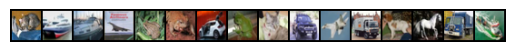

In [9]:
print('Running C&W 9 x 10000 attack')
cwattacker = CarliniWagnerL2(device=device,
                             image_constraints=(0, 1),
                             num_classes=10)

start = time.time()
cw_atk = cwattacker.attack(model, x, labels=y, targeted=False)
cw_time = time.time() - start
print('Completed in {:.2f}s'.format(cw_time))

plt.imshow(make_grid(cw_atk.cpu(), nrow=16).permute(1,2,0))
plt.axis('off');

C&W 4 x 25 done in 0.9s: Success: 100.00%, Mean L2: 6.6092, Median L2: 8.8581.
C&W 9 x 10000 done in 1780.0s: Success: 100.00%, Mean L2: 0.0928, Median L2: 0.0440.
DDN 100 done in 14.1s: Success: 100.00%, Mean L2: 0.0784, Median L2: 0.0479.

Figure: top row: original images; 2nd: C&W 4x25 atk; 3rd: C&W 9x10000 atk; 4th: DDN 100 atk


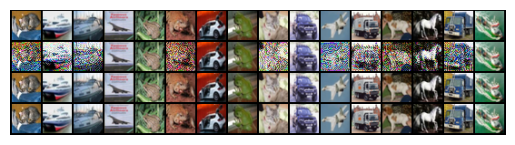

In [10]:
all_imgs = torch.cat((x, cw100_atk, cw_atk, ddn_atk))
img_grid = make_grid(all_imgs, nrow=16, pad_value=0)
plt.imshow(img_grid.cpu().permute(1, 2, 0))
plt.axis('off')

# Print metrics
pred_orig = model(x).argmax(dim=1).cpu()
pred_cw = model(cw_atk).argmax(dim=1).cpu()
pred_cw100 = model(cw100_atk).argmax(dim=1).cpu()
pred_ddn = model(ddn_atk).argmax(dim=1).cpu()
print('C&W 4 x 25 done in {:.1f}s: Success: {:.2f}%, Mean L2: {:.4f}, Median L2: {:.4f}.'.format(
cw100_time,
(pred_cw100 != y.cpu()).float().mean().item() * 100,
l2_norm(cw100_atk - x).mean().item(),
l2_norm(cw100_atk - x).median().item()
))
print('C&W 9 x 10000 done in {:.1f}s: Success: {:.2f}%, Mean L2: {:.4f}, Median L2: {:.4f}.'.format(
cw_time,
(pred_cw != y.cpu()).float().mean().item() * 100,
l2_norm(cw_atk - x).mean().item(),
l2_norm(cw_atk - x).median().item()
))
print('DDN 100 done in {:.1f}s: Success: {:.2f}%, Mean L2: {:.4f}, Median L2: {:.4f}.'.format(
ddn_time,
(pred_ddn != y.cpu()).float().mean().item() * 100,
l2_norm(ddn_atk - x).mean().item(),
l2_norm(ddn_atk - x).median().item()
))
print()
print('Figure: top row: original images; 2nd: C&W 4x25 atk; 3rd: C&W 9x10000 atk; 4th: DDN 100 atk')